In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Acquire

Creating initial functions related to acquisition of the dataset to be used. Using these functions I will build out an acquire.py file that I can use in my final report.


In [2]:
def get_telco_data():
    ''' This function allows access to the requisite telco dataset. It accesses a local cache of the data if there is a 
    local copy stored. If no local copy exists, it uses credentials stored in env.py to make a call to the SQL 
    database, returns the data and then creates a local cached copy in a .csv file so as to not need to query the SQL 
    database in the future. 
    
    The stored local copy is called telco.csv 
    
    If at any point a fresh copy of the SQL database is needed, the original cached .csv must be deleted.
    
    The function returns a dataframe of the telco data.
    '''
    
    filename = "telco.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        query = '''
        SELECT * 
        FROM customers
        JOIN contract_types USING (contract_type_id)
        JOIN payment_types USING (payment_type_id)
        JOIN internet_service_types USING (internet_service_type_id);     
        '''
        url = env.get_db_url('telco_churn')
        df = pd.read_sql(query, url)
        df.to_csv(filename, index=False)

        return df  
    
df = get_telco_data()
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [3]:
df.shape

(7043, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [6]:
# Small function getting me a value_count of all object columns; this gives me a preliminary look at the data.

def obj_val_cnt(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(df[col].value_counts(dropna=False))
obj_val_cnt(df)

0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Na

**Above we see that the total_charges column is treated as an object, I need to fix this and deal with any possible nulls as soon as possible before looking at any of the data.  This is a prepare task that will be done below and added to the prepare.py script.**

In [7]:
# This function gives me a dataframe with summary statistics with range added on the end.

def describe_with_range(df):
    summary_stats = df.describe().T
    summary_stats['range'] = summary_stats['max'] - summary_stats['min']
    return summary_stats
describe_with_range(df)

,count,mean,std,min,25%,50%,75%,max,range
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00,2.0
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00,3.0
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00,2.0
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00,1.0
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,72.0
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,100.5


# Prepare
Doing some initial exploration of the dataframe will allow me to find any data that needs to be changed, converted or transformed for use in the model later.  Some of these functions will go into my prepare.py script.

In [8]:
# This follows my discovery above about the total_charges column being an object column.

# This finds all "nulls" which take the form of an empty space ' ' here since this is an object column, and replaces 
# them with zeros and then converts the column to a numeric one.

df.total_charges.replace(' ', '0', inplace=True)
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [9]:
# Based on the df.info() above I don't think there are any nulls, but the following will show us if there are.

df.isnull().sum()

internet_service_type_id    0
payment_type_id             0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
payment_type                0
internet_service_type       0
dtype: int64

In [10]:
df.internet_service_type.value_counts(), df.internet_service_type_id.value_counts()

(Fiber optic    3096
 DSL            2421
 None           1526
 Name: internet_service_type, dtype: int64,
 2    3096
 1    2421
 3    1526
 Name: internet_service_type_id, dtype: int64)

In [11]:
df.payment_type_id.value_counts(), df.payment_type.value_counts()

(1    2365
 2    1612
 3    1544
 4    1522
 Name: payment_type_id, dtype: int64,
 Electronic check             2365
 Mailed check                 1612
 Bank transfer (automatic)    1544
 Credit card (automatic)      1522
 Name: payment_type, dtype: int64)

In [12]:
df.contract_type_id.value_counts(), df.contract_type.value_counts()

(1    3875
 3    1695
 2    1473
 Name: contract_type_id, dtype: int64,
 Month-to-month    3875
 Two year          1695
 One year          1473
 Name: contract_type, dtype: int64)

In [13]:
df.phone_service.value_counts(), df.multiple_lines.value_counts()

(Yes    6361
 No      682
 Name: phone_service, dtype: int64,
 No                  3390
 Yes                 2971
 No phone service     682
 Name: multiple_lines, dtype: int64)

In [14]:
df[(df.phone_service == 'No') & (df.multiple_lines == 'No phone service')].phone_service.value_counts()

No    682
Name: phone_service, dtype: int64

In [15]:
# From the above 4 cells we see that the columns internet_service_type, payment_type, and contract_type all correspond
# direclty to internet_service_type_id, payment_type_id, and contract_type_id; additionally, the information in the 
# phone_service column is 100% reproduced with ADDITIONAL info in the multiple_lines column.  Thus I will be dropping 
# internet_service_type_id, payment_type_id, contract_type_id, and phone_service as redundant columns.

df.drop(columns = ['internet_service_type_id', 'payment_type_id', 'contract_type_id', 'phone_service'], inplace=True)

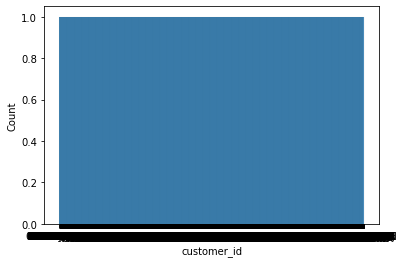

Count of variables in customer_id: 
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
--------------------


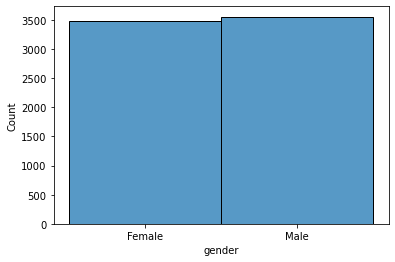

Count of variables in gender: 
Male      3555
Female    3488
Name: gender, dtype: int64
--------------------


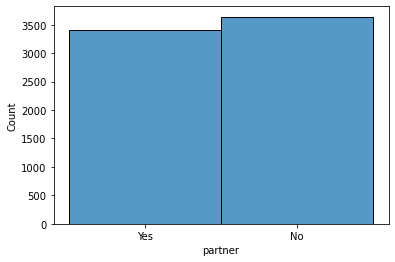

Count of variables in partner: 
No     3641
Yes    3402
Name: partner, dtype: int64
--------------------


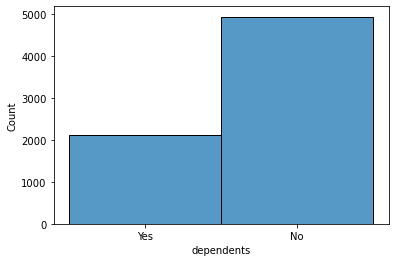

Count of variables in dependents: 
No     4933
Yes    2110
Name: dependents, dtype: int64
--------------------


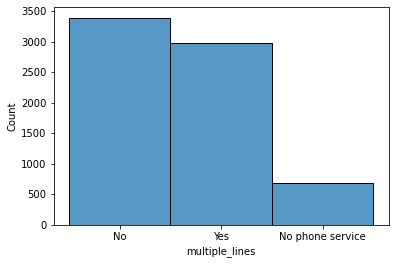

Count of variables in multiple_lines: 
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
--------------------


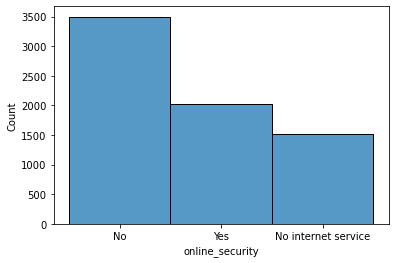

Count of variables in online_security: 
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
--------------------


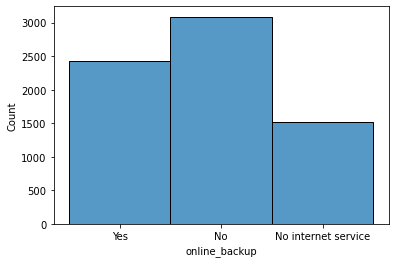

Count of variables in online_backup: 
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
--------------------


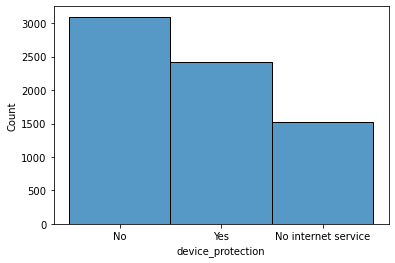

Count of variables in device_protection: 
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
--------------------


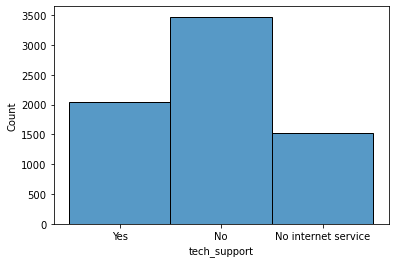

Count of variables in tech_support: 
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
--------------------


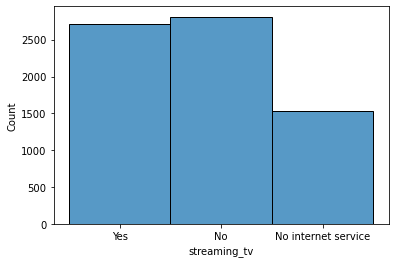

Count of variables in streaming_tv: 
No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64
--------------------


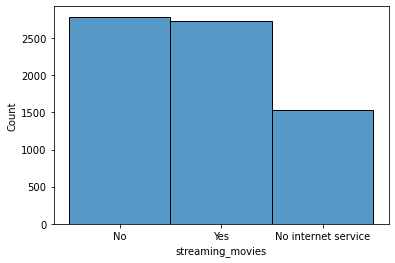

Count of variables in streaming_movies: 
No                     2785
Yes                    2732
No internet service    1526
Name: streaming_movies, dtype: int64
--------------------


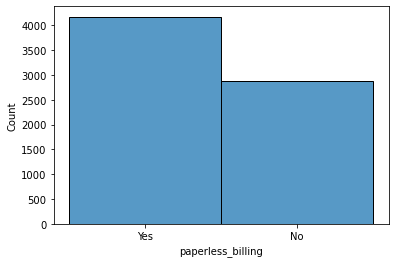

Count of variables in paperless_billing: 
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
--------------------


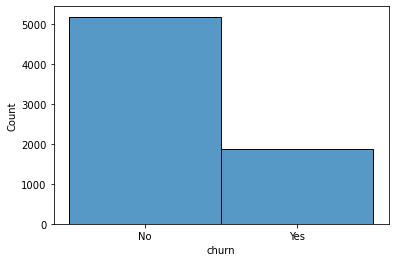

Count of variables in churn: 
No     5174
Yes    1869
Name: churn, dtype: int64
--------------------


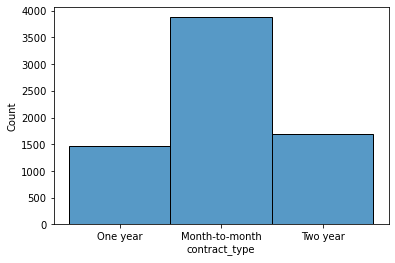

Count of variables in contract_type: 
Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64
--------------------


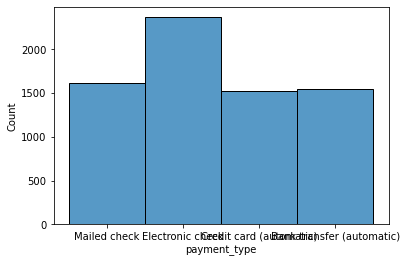

Count of variables in payment_type: 
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64
--------------------


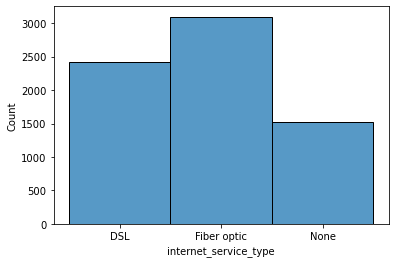

Count of variables in internet_service_type: 
Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64
--------------------


In [16]:
# Getting histograms for each of the categorical columns in the telco dataset.  This will give me a good sense of how 
# each categorical column is shaped.

cat_cols = df.select_dtypes('object').columns

for col in cat_cols:
    sns.histplot(df[col])
    plt.show()
    print(f"Count of variables in {col}: \n{df[col].value_counts()}\n--------------------")

For several of the categorical columns displayed above there are three choices that look like:
- Yes
- No
- No phone service / No internet service

Since this information about "No phone service / No internet service" is also contained in the "phone_service" and "internet_service_type" columns, this data is redundant for any other column listing "No phone service / No internet service".

As such I will be changing all instances of "No phone service / No internet service" to No. These categorical variables will have an output of either "Yes" or "No".

In [17]:
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.replace('No phone service', 'No')
        df[col] = df[col].str.replace('No internet service', 'No')

In [18]:
df.online_security.value_counts()

No     5024
Yes    2019
Name: online_security, dtype: int64

Further, I need to change some of the categorical variables to snake case to make things easier later on.

In [19]:
df['internet_service_type'] = df.internet_service_type.str.replace('Fiber optic', 'fiber_optic')
df['payment_type'] = df.payment_type.str.replace('Electronic check', 'electronic_check')
df['payment_type'] = df.payment_type.str.replace('^Bank transfer', 'bank_transfer_automatic', regex = True)
df['payment_type'] = df.payment_type.str.replace('Mailed check', 'mailed_check')
df['payment_type'] = df.payment_type.str.replace("^Credit card", 'credit_card_automatic', regex = True)
df['contract_type'] = df.contract_type.str.replace('Two year', 'two_year')
df['contract_type'] = df.contract_type.str.replace('One year', 'one_year')
df['contract_type'] = df.contract_type.str.replace('Month-to-month', 'month_to_month')

In [20]:
df.payment_type.value_counts()

electronic_check                       2365
mailed_check                           1612
bank_transfer_automatic (automatic)    1544
credit_card_automatic (automatic)      1522
Name: payment_type, dtype: int64

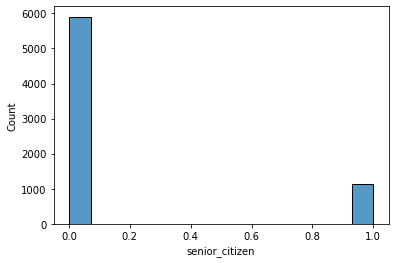

Count of variables in senior_citizen: 
0    5901
1    1142
Name: senior_citizen, dtype: int64
--------------------
Mean of variables in senior_citizen: 
0.1621468124378816
--------------------


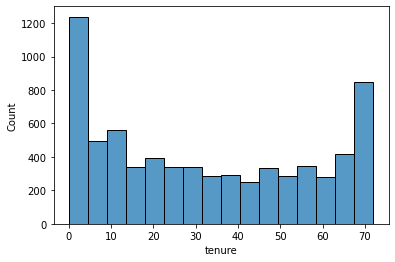

Count of variables in tenure: 
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
--------------------
Mean of variables in tenure: 
32.37114865824223
--------------------


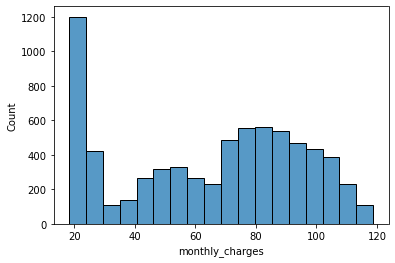

Count of variables in monthly_charges: 
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
116.55     1
106.85     1
68.55      1
108.80     1
67.85      1
Name: monthly_charges, Length: 1585, dtype: int64
--------------------
Mean of variables in monthly_charges: 
64.7616924605992
--------------------


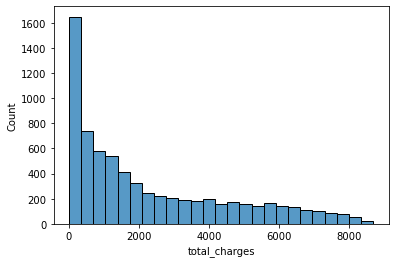

Count of variables in total_charges: 
0.00       11
20.20      11
19.75       9
19.90       8
20.05       8
           ..
2387.75     1
6302.80     1
2058.50     1
829.55      1
3707.60     1
Name: total_charges, Length: 6531, dtype: int64
--------------------
Mean of variables in total_charges: 
2279.7343035638196
--------------------


In [21]:
# This gets us some preliminary histograms of the numeric columns in the dataset.  This gives me an idea of how the 
# numerical columns are shaped.
num_cols = df.select_dtypes('number').columns

for col in num_cols:
    sns.histplot(df[col])
    plt.show()
    print(f"Count of variables in {col}: \n{df[col].value_counts()}\n--------------------")
    print(f"Mean of variables in {col}: \n{df[col].mean()}\n--------------------")

In [22]:
# From the above cell, we can see there are 11 total customers who have 0 total_charges and 11 total customers who
# have a tenure of 0. I want to compare those both to churn to determine if those 11 customers are worth keeping.

df[df.total_charges == 0]

# None churned who had a tenure of total charges and tenure of 0. Since they have no possiblity of churning yet, I'm 
# going to drop these eleven customers from the dataset as to make the data cleaner.

,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
945,1371-DWPAZ,Female,0,Yes,Yes,0,No,Yes,Yes,Yes,Yes,Yes,No,No,56.05,0.0,No,two_year,credit_card_automatic (automatic),DSL
1731,2520-SGTTA,Female,0,Yes,Yes,0,No,No,No,No,No,No,No,No,20.00,0.0,No,two_year,mailed_check,None
1906,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,0.0,No,two_year,bank_transfer_automatic (automatic),DSL
2025,2923-ARZLG,Male,0,Yes,Yes,0,No,No,No,No,No,No,No,Yes,19.70,0.0,No,one_year,mailed_check,None
2176,3115-CZMZD,Male,0,No,Yes,0,No,No,No,No,No,No,No,No,20.25,0.0,No,two_year,mailed_check,None
2250,3213-VVOLG,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,25.35,0.0,No,two_year,mailed_check,None
2855,4075-WKNIU,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,0.0,No,two_year,mailed_check,DSL
3052,4367-NUYAO,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,25.75,0.0,No,two_year,mailed_check,None
3118,4472-LVYGI,Female,0,Yes,Yes,0,No,Yes,No,Yes,Yes,Yes,No,Yes,52.55,0.0,No,two_year,bank_transfer_automatic (automatic),DSL
4054,5709-LVOEQ,Female,0,Yes,Yes,0,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,0.0,No,two_year,mailed_check,DSL


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

In [24]:
df.drop(df[df.total_charges == 0].index, inplace=True)
df.info()
# Dropped 11 customers. Total rows from 7043 to 7032

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7032 non-null   object 
 1   gender                 7032 non-null   object 
 2   senior_citizen         7032 non-null   int64  
 3   partner                7032 non-null   object 
 4   dependents             7032 non-null   object 
 5   tenure                 7032 non-null   int64  
 6   multiple_lines         7032 non-null   object 
 7   online_security        7032 non-null   object 
 8   online_backup          7032 non-null   object 
 9   device_protection      7032 non-null   object 
 10  tech_support           7032 non-null   object 
 11  streaming_tv           7032 non-null   object 
 12  streaming_movies       7032 non-null   object 
 13  paperless_billing      7032 non-null   object 
 14  monthly_charges        7032 non-null   float64
 15  tota

In [25]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7032 non-null   object 
 1   gender                 7032 non-null   object 
 2   senior_citizen         7032 non-null   int64  
 3   partner                7032 non-null   object 
 4   dependents             7032 non-null   object 
 5   tenure                 7032 non-null   int64  
 6   multiple_lines         7032 non-null   object 
 7   online_security        7032 non-null   object 
 8   online_backup          7032 non-null   object 
 9   device_protection      7032 non-null   object 
 10  tech_support           7032 non-null   object 
 11  streaming_tv           7032 non-null   object 
 12  streaming_movies       7032 non-null   object 
 13  paperless_billing      7032 non-null   object 
 14  monthly_charges        7032 non-null   float64
 15  tota

In [26]:
# Makes a list for categorical columns which we want encoded for modeling later 
# (this will be a list of all categorical columns except customer_id)

dummies_list = df.select_dtypes(object).columns
dummies_list = dummies_list.drop('customer_id')

dummy_df = pd.get_dummies(df[dummies_list], drop_first=True)
df = pd.concat([df, dummy_df], axis = 1)

In [27]:
# We can see here the categorical columns have been properly encoded.
df.head(1).T

,0
customer_id,0002-ORFBO
gender,Female
senior_citizen,0
partner,Yes
dependents,Yes
tenure,9
multiple_lines,No
online_security,No
online_backup,Yes
device_protection,No


In [28]:
def split_telco(df):
    '''
    Takes in a cleaned telco dataframe, splits it into train, validate and test subgroups stratifying it on the target
    of churn and then returns those subgroups.
    
    Arguments: df - a cleaned pandas dataframe with the expected feature names and columns in the telco dataset
    Return: train, validate, test - dataframes ready for the exploration and model phases.
    '''
    train, test = train_test_split(df, train_size = 0.8, stratify = df.churn_Yes, random_state = 1234)
    train, validate = train_test_split(train, train_size = 0.7, stratify = train.churn_Yes, random_state = 1234)
    return train, validate, test

train, validate, test = split_telco(df)

In [29]:
train.shape, validate.shape, test.shape

((3937, 39), (1688, 39), (1407, 39))

In [30]:
# This shows the proportion of each subgroup which contains a customer who churns.  They are all essentially 
# equivalent.

train.churn_Yes.mean(), validate.churn_Yes.mean(), test.churn_Yes.mean()

(0.2656845313690627, 0.2659952606635071, 0.2658137882018479)

In [31]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,online_security,online_backup,device_protection,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic (automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic
4491,6339-RZCBJ,Male,0,No,No,48,No,No,Yes,Yes,...,1,0,0,0,1,1,0,0,0,0
2346,3359-DSRKA,Female,0,Yes,Yes,58,No,No,No,No,...,0,1,0,0,1,0,0,1,1,0
770,1121-QSIVB,Female,0,No,Yes,44,Yes,No,Yes,No,...,1,1,0,1,0,0,0,1,0,0
5155,7249-WBIYX,Male,0,Yes,No,10,Yes,No,No,No,...,0,1,1,0,0,0,1,0,0,1
189,0305-SQECB,Female,0,No,Yes,11,No,Yes,No,No,...,0,1,0,1,0,0,0,1,0,0


Data is now split into 3 subgroups with the target variable churn stratified amongst them.

# Explore (Exploratory Data Analysis)
This is where I will be doing more in depth univariate, bivariate, and multivariate exploration of the data to determine what are features of the target variable churn that I want to use for my model.

In [32]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type', 'gender_Male',
       'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes', 'contract_type_one_year',
       'contract_type_two_year',
       'payment_type_credit_card_automatic (automatic)',
       'payment_type_electronic_check', 'payment_type_mailed_check',
       'internet_service_type_None', 'internet_service_type_fiber_optic'],
      dtype='object')

In [33]:
plt.rc('figure', figsize=(14, 10))

In [34]:
train_explore = train.drop(columns = ['customer_id', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
        'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 
        'streaming_movies_Yes', 'paperless_billing_Yes', 'churn_Yes', 'contract_type_one_year', 'contract_type_two_year',
        'payment_type_credit_card_automatic (automatic)', 'payment_type_electronic_check', 'payment_type_mailed_check',
        'internet_service_type_None', 'internet_service_type_fiber_optic'])

In [35]:
train_explore.head(1).T

,4491
gender,Male
senior_citizen,0
partner,No
dependents,No
tenure,48
multiple_lines,No
online_security,No
online_backup,Yes
device_protection,Yes
tech_support,Yes


### Continous Variables
Exploring continous variables

<AxesSubplot:>

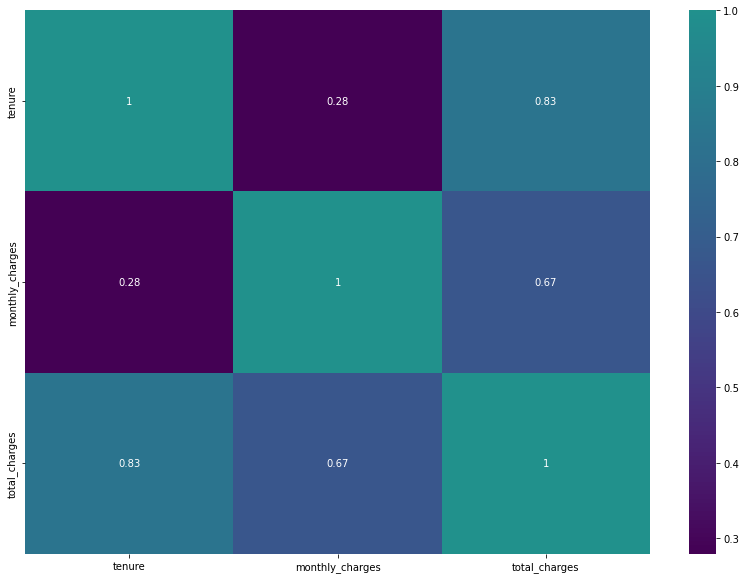

In [36]:
# Viewing all continuous data in a heatmap to see if there is any strong correlation present between features.
cont_var = train_explore.drop('senior_citizen', axis=1)

sns.heatmap(cont_var.corr(), cmap='viridis', center=1, annot=True)

# It looks as though tenure and total_charges might be interrelated so depending on how the models perform later, I may want to 
# exclude 

#### Takeaways from Heatmap:
- There are not many continuous variables to compare in the Telco dataset as most are categorical variables.
- Of the three that remain, tenure and total_charges are correlated most strongly 
    - depending on how the models perform later, I may want to exclude either tenure or total charges to see if this makes a clearer picture for the model to predict on.


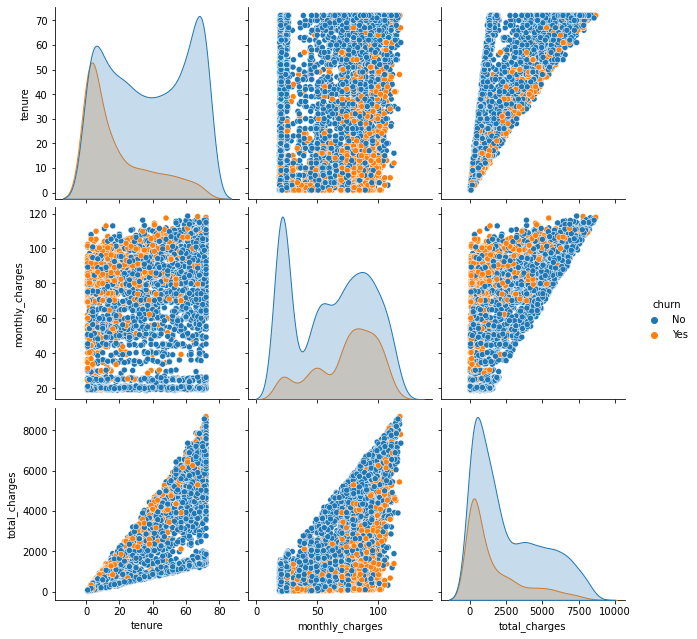

In [37]:
sns.pairplot(cont_var, hue='churn', height = 3)
plt.show()

#### Takeaways from pairplot:
- It looks as though there are significant differences between churn and no churn for all of the given features: total_charges, monthly_charges, and tenure.
- It also looks like higher monthly charges and lower tenure may be a driver for churn.
- I will need to hypothesis test these.

**Hypothesis testing for continous variables**

<AxesSubplot:xlabel='monthly_charges', ylabel='Count'>

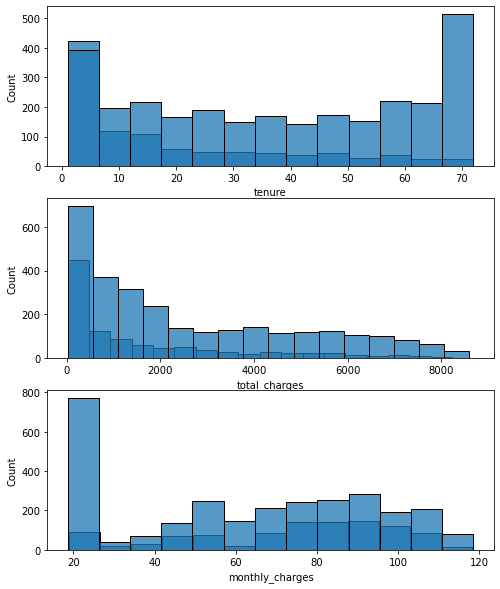

In [38]:
# I want to compare these continous variables with a T-test.  Checking for normality in graphs below.
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
sns.histplot(data=train_explore[train_explore.churn == 'Yes'].tenure)
sns.histplot(data=train_explore[train_explore.churn == 'No'].tenure)
plt.subplot(3,1,2)
sns.histplot(data=train_explore[train_explore.churn == 'Yes'].total_charges)
sns.histplot(data=train_explore[train_explore.churn == 'No'].total_charges)
plt.subplot(3,1,3)
sns.histplot(data=train_explore[train_explore.churn == 'Yes'].monthly_charges)
sns.histplot(data=train_explore[train_explore.churn == 'No'].monthly_charges)

In [39]:
print(f"The total entries for churn is: {train_explore[train_explore.churn == 'Yes'].shape[0]}.")
print(f"The total entries for no churn is: {train_explore[train_explore.churn == 'No'].shape[0]}.")

The total entries for churn is: 1046.
The total entries for no churn is: 2891.


In [40]:
# Checking for variance with levene

stats.levene(train_explore[train_explore.churn == 'Yes'].tenure, train_explore[train_explore.churn == 'No'].tenure)
# No equal variance for tenure.

LeveneResult(statistic=208.2260074776894, pvalue=4.918222765354178e-46)

In [41]:
stats.levene(train_explore[train_explore.churn == 'Yes'].total_charges, train_explore[train_explore.churn == 'No'].total_charges)
# No equal variance for total_charges.

LeveneResult(statistic=85.78117491510639, pvalue=3.220782732845082e-20)

In [42]:
stats.levene(train_explore[train_explore.churn == 'Yes'].monthly_charges, train_explore[train_explore.churn == 'No'].monthly_charges)
# No equal variance for monthly_charges

LeveneResult(statistic=161.54749042499748, pvalue=2.6620656867750108e-36)

For my t-tests:
- Even though the graphs aren't normal, they are large enough to assume normality due to the central limit theorem.
- They are independent of one another by definition.
- None of the variables have equal variance when split between churn and no churn. I will set equal_var=False.

I will run a two sample, two tailed t-test for each continous variable to see if there is any signficant difference between churn and no churn.

**Hypothesis 1:**

$H_{0}$ There is no difference in tenure between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in tenure between customers who churned and customers who didn't churn.

In [43]:
alpha = .05

In [44]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].tenure, train_explore[train_explore.churn == 'No'].tenure, equal_var=False)

t, p

(-25.10180881507048, 1.0184830572431322e-122)

In [45]:
p < alpha

True

Reject the Null; There is a statistically significant difference in tenure between customers who churned and customers who didn't churn.


**Hypothesis 2:**

$H_{0}$ There is no difference in monthly_charges between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.

In [46]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].monthly_charges, train_explore[train_explore.churn == 'No'].monthly_charges, equal_var=False)

t, p

(12.072008878640396, 1.4724622662838922e-32)

In [47]:
p < alpha

True

Reject the Null; There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.


**Hypothesis 3:**

$H_{0}$ There is no difference in total_charges between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in total_charges between customers who churned and customers who didn't churn.

In [48]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].total_charges, train_explore[train_explore.churn == 'No'].total_charges, equal_var=False)

t, p

(-13.516671842845568, 4.576798001002561e-40)

In [49]:
p < alpha

True

Reject the Null; There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.


**Results from t-tests of continous variables**

- All continous variables when split between customers who churned and didn't churn show statistically significant differences.
- Tenure had the strongest results.
- I will use all continuous variables as features for modeling.

### Categorical Variables
Exploring Categorical variables

In [50]:
train_explore.info()

explore_cat = train_explore.select_dtypes(object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 4491 to 3781
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 3937 non-null   object 
 1   senior_citizen         3937 non-null   int64  
 2   partner                3937 non-null   object 
 3   dependents             3937 non-null   object 
 4   tenure                 3937 non-null   int64  
 5   multiple_lines         3937 non-null   object 
 6   online_security        3937 non-null   object 
 7   online_backup          3937 non-null   object 
 8   device_protection      3937 non-null   object 
 9   tech_support           3937 non-null   object 
 10  streaming_tv           3937 non-null   object 
 11  streaming_movies       3937 non-null   object 
 12  paperless_billing      3937 non-null   object 
 13  monthly_charges        3937 non-null   float64
 14  total_charges          3937 non-null   float64
 15  c

In [51]:
# Concatenating senior_citizen to the objects as it is technically a categorical variable encoded as a numerical one.
explore_cat = pd.concat([explore_cat, train_explore.senior_citizen], axis = 1)
explore_cat.head()

,gender,partner,dependents,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,contract_type,payment_type,internet_service_type,senior_citizen
4491,Male,No,No,No,No,Yes,Yes,Yes,Yes,Yes,No,No,two_year,credit_card_automatic (automatic),DSL,0
2346,Female,Yes,Yes,No,No,No,No,No,No,No,Yes,No,two_year,mailed_check,None,0
770,Female,No,Yes,Yes,No,Yes,No,No,Yes,Yes,Yes,No,one_year,mailed_check,DSL,0
5155,Male,Yes,No,Yes,No,No,No,No,Yes,No,Yes,Yes,month_to_month,electronic_check,fiber_optic,0
189,Female,No,Yes,No,Yes,No,No,Yes,No,No,Yes,No,one_year,mailed_check,DSL,0


In [52]:
def explore_categoricals(df, target, alpha = .05):
    '''
    This function takes in a subset of the train dataframe which contains on the categorical variable columns and runs a Chi 
    Test of Independence on all variables in comparison to the target variable. It prints the null and alternative hypotheses
    for each comparison and displays results indicating whether the results reject or fail to reject the null hypothesis based
    on the supplied alpha.  Returns a dataframe containing the variable (feature) name and the p value of chi2 test for all 
    variables having a p < alpha.
    
    Arguments:
                df - a subset of the train dataframe containing ONLY categorical variables
                target - specifies the target variable to compare with all other variables in the subset df
                alpha - a specified alpha for statistical significance. Default set to .05
                
    Return: dataframe with variable names and p value results from the chi2 test for all variables where p < alpha.
    
    '''
    print("Exploring relationships between categorical variables and the target categorical variable.")
    print("----------------------------------\n")
    stat_significant = []
    p_value= []
    not_stat_significant = []
    a = alpha
    for col in explore_cat.columns:
        print(f"Null Hypothesis: There is no relationship between {col} and {target}.")
        print(f"Alternative Hypothesis: There is a relationship between {col} and {target}.")
        print("----------------------------------\n")
        print("Results of Chi Squared Test of Independence")
        observed = pd.crosstab(df[col], df[target])
        chi2, p, degf, expected = stats.chi2_contingency(observed)
        if p < a:
            print(f"P ({p}) is less than alpha ({a}).")
            print(f"I reject the null hypothesis. There is a statistically significant relationship between {col} and {target}.")
            stat_significant.append(col)
            p_value.append(p)
        else:
            print(f"P ({p}) is more than alpha ({a}).")
            print(f"I fail to reject the null hypothesis that there is no relationship between {col} and {target}.")
            not_stat_significant.append(col)
        print("\n----------------------------------\n")
    
    print(f"Statistically signficant relationships with the target variable ({target}) were found with the following features:")
    print(stat_significant)
    print("----------------------------------\n")
    print(f"Statistically signficant relationships with the target variable ({target}) were NOT found with the following features:")
    print(not_stat_significant)
    return pd.DataFrame({"feature": stat_significant, "p_value": p_value})


In [53]:
chi2_results = explore_categoricals(explore_cat, 'churn')

Exploring relationships between categorical variables and the target categorical variable.
----------------------------------

Null Hypothesis: There is no relationship between gender and churn.
Alternative Hypothesis: There is a relationship between gender and churn.
----------------------------------

Results of Chi Squared Test of Independence
P (0.2467776583022185) is more than alpha (0.05).
I fail to reject the null hypothesis that there is no relationship between gender and churn.

----------------------------------

Null Hypothesis: There is no relationship between partner and churn.
Alternative Hypothesis: There is a relationship between partner and churn.
----------------------------------

Results of Chi Squared Test of Independence
P (6.453485965478912e-22) is less than alpha (0.05).
I reject the null hypothesis. There is a statistically significant relationship between partner and churn.

----------------------------------

Null Hypothesis: There is no relationship between 

In [54]:
chi2_results.sort_values('p_value')

,feature,p_value
9,churn,0.000000e+00
10,contract_type,3.957406e-140
12,internet_service_type,2.781527e-77
11,payment_type,7.032806e-72
8,paperless_billing,6.745165e-33
1,dependents,2.424982e-28
2,online_security,1.257737e-27
5,tech_support,1.316224e-25
13,senior_citizen,3.088301e-25
0,partner,6.453486e-22


**Results from Chi Squared test of categorical variables**

- Both gender and multiple_lines showed NO statistically significant relationship with churn.  These variables can be discarded and not used as features in my models.
- All other variables had statistical signficance showing a relationship between them and churn.  They include:
    - partner
    - dependents
    - online_security
    - online_backup
    - device_protection
    - tech_support
    - streaming_tv
    - streaming_movies
    - paperless_billing
    - contract_type
    - payment_type
    - internet_service_type
    - senior_citizen
    
- I will use all categorical variables from the previous list as features for initial modeling.
    - contract_type, internet_service_type, and payment_type are *strongly* related from persepctive of statistical likelihood.
- If I have time, I will come back later to determine if certain categorical variables may have a relationship with one another that would indicate one of them need not be included in the model. This would hopefully add clarity and predictive power.

# Modeling
I will be creating initial models with basic hyperparameters for the following types:
- Decision Tree
- Random Forest
- K-nearest neighbors
- Logistic Regression

If there is time I would also like to try models using:
- Support Vector Machine (SVM)
- Naive Bayes

I will also need to create a function I will call premodeling that will do final processing of the dataframe to make it usable for the models based on the features I want to include.

In [55]:
# I need to do some final clean up post exploration to set up the data for modeling.  This will involve removing all non-encoded
# columns and dropping columns I determinded during exploration to not be useful features.

def pre_model(train, validate, test, drop_columns_list = []):
    '''
    This function does any final preparation necessary prior to modeling. It takes in the train, validate, test subsets made 
    previously does transformations (e.g. dropping non-encoded columns) and returns the final versions of train, validate, test.
    
    Arguments:
        train - a subset of the entire dataframe, previously split, to be used for training my models
        validate - a subset of the entire dataframe, previously split, to be used for validation of my models
        test - a subset of the entire dataframe, previously split, to be used for testing my final model
        drop_columns_list = a list of columns determined during EDA to not be useful features for modeling
   
   Returns: train, validate, test dataframes ready for modeling
    '''
    # makes a list of unencoded columns to drop PLUS puts customer_id back in (this is necessary for a later step 
    # involving customer_id)
    unencoded_train_to_drop = train.select_dtypes('object').columns
    unencoded_train_to_drop = unencoded_train_to_drop.drop('customer_id')
    
    unencoded_validate_to_drop = validate.select_dtypes('object').columns
    unencoded_validate_to_drop = unencoded_validate_to_drop.drop('customer_id')
    
    unencoded_test_to_drop = test.select_dtypes('object').columns
    unencoded_test_to_drop = unencoded_test_to_drop.drop('customer_id')
    
    
    # Drops all unencoded columns
    train = train.drop(columns = (unencoded_train_to_drop))
    validate = validate.drop(columns = (unencoded_validate_to_drop))
    test = test.drop(columns = (unencoded_test_to_drop))
    
    # Drops columns in the drop_columns_list
    train = train.drop(columns = drop_columns_list)
    validate = validate.drop(columns = drop_columns_list)
    test = test.drop(columns = drop_columns_list)
    
    return train, validate, test

In [56]:
train, validate, test = pre_model(train, validate, test, drop_columns_list= ['gender_Male', 'multiple_lines_Yes'])

In [57]:
train.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic (automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic
4491,6339-RZCBJ,0,48,78.90,3771.50,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
2346,3359-DSRKA,0,58,19.85,1158.85,1,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
770,1121-QSIVB,0,44,77.55,3471.10,0,1,0,1,0,...,1,1,0,1,0,0,0,1,0,0
5155,7249-WBIYX,0,10,85.60,813.85,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1
189,0305-SQECB,0,11,36.05,402.60,0,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0


In [58]:
validate.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic (automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic
4959,6981-TDRFT,0,44,54.30,2317.10,1,1,0,0,1,...,1,1,0,1,0,0,1,0,0,0
3623,5135-RDDQL,0,63,50.65,3221.25,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
6520,9251-WNSOD,0,67,75.10,5064.45,1,0,1,1,1,...,1,0,0,1,0,0,0,1,0,0
2470,3536-IQCTX,1,32,85.30,2661.10,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
1878,2724-FJDYW,0,39,54.85,2191.70,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [59]:
test.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic (automatic),payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic
6114,8659-HDIYE,1,64,74.65,4869.35,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0
1447,2137-DQMEV,0,68,44.80,2983.65,1,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
6379,9039-ZVJDC,0,3,19.10,53.05,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1015,1465-WCZVT,0,3,19.65,60.65,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1852,2688-BHGOG,1,9,79.55,718.55,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1


Data is now completely ready to do modeling.

**Setting a Baseline**

I now need to define my baseline accuracy to see what the models need to beat.

In [60]:
# The highest value is showing 0 which corresponds to no churn.
train.churn_Yes.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [61]:
1 - train.churn_Yes.mean()

0.7343154686309372

My baseline is 73.4%.  This means that if I were to guess churn_Yes = 0 (no churn) for every customer, I would be correct 73.4% of the time. My final model needs to beat this.

### Decision Tree

I will start with a single model using standard hyperparameters and tweak it later.

In [62]:
# Define X and y train
X_train = train.drop(columns=['churn_Yes', 'customer_id'])
y_train = train.churn_Yes

# Define X and y validate
X_validate = validate.drop(columns=['churn_Yes', 'customer_id'])
y_validate = validate.churn_Yes

# Define X and y test
X_test = test.drop(columns=['churn_Yes', 'customer_id'])
y_test = test.churn_Yes

In [63]:
# Create the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model to the train dataset
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [64]:
# Score the model on the train dataset

print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_train, y_train),4)*100}%')


Accuracy of Decision Tree classifier on training set: 78.13%


In [65]:
# Make predictions based on the model
y_pred = clf.predict(X_train)

In [66]:
# Printing a classification report for train using the model's predictions

pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.800474,0.935316,0.862658,2891.000000
1,0.665474,0.355641,0.463551,1046.000000
accuracy,0.781306,0.781306,0.781306,0.781306
macro avg,0.732974,0.645479,0.663104,3937.000000
weighted avg,0.764606,0.781306,0.756621,3937.000000


I'm not super happy with these initial results so I will make a function that runs through varying max_depth values to help find the best possible result for this one specific hyperparameter.

In [67]:
# This is a function to test how max_depth affects the accuracy on both the training and the validate set to hopefully find the 
# optimal depth.
def max_depth_iterator(X, y):
    for n in range(1,15):
        clf = DecisionTreeClassifier(max_depth=n, random_state=123)
        clf.fit(X, y)
        print(f'Accuracy of Decision Tree classifier on training set with a max_depth of {n}: {round(clf.score(X_train, y_train),4)*100}%')
        print(f'Accuracy of Decision Tree classifier on validate set with a max_depth of {n}: {round(clf.score(X_validate, y_validate),4)*100}%')
        print("-----------------------------------")

In [68]:
max_depth_iterator(X_train, y_train)

Accuracy of Decision Tree classifier on training set with a max_depth of 1: 73.42999999999999%
Accuracy of Decision Tree classifier on validate set with a max_depth of 1: 73.4%
-----------------------------------
Accuracy of Decision Tree classifier on training set with a max_depth of 2: 78.13%
Accuracy of Decision Tree classifier on validate set with a max_depth of 2: 79.5%
-----------------------------------
Accuracy of Decision Tree classifier on training set with a max_depth of 3: 78.13%
Accuracy of Decision Tree classifier on validate set with a max_depth of 3: 79.5%
-----------------------------------
Accuracy of Decision Tree classifier on training set with a max_depth of 4: 78.49000000000001%
Accuracy of Decision Tree classifier on validate set with a max_depth of 4: 79.97999999999999%
-----------------------------------
Accuracy of Decision Tree classifier on training set with a max_depth of 5: 79.3%
Accuracy of Decision Tree classifier on validate set with a max_depth of 5: 8

Based on this initial trial, manipulating max_depth results in a depth of 6 producing the best results of 80.4% on the train and 80.3% on the validate set.  I may be able to get it higher but this is a good starting number.

### Random Forest

I will start with a single model using standard hyperparameters and tweak it later.

In [69]:
# Using standard hyperparameters to get an idea of the accuracy of random forest.  Will iterate more later.
rf = RandomForestClassifier(max_depth=3, random_state=123, min_samples_leaf = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=123)

In [70]:
# Scoring the model on the train dataset
print(f'Accuracy of Random Forest classifier on training set: {round(rf.score(X_train, y_train),4)*100}%')

Accuracy of Random Forest classifier on training set: 78.0%


In [71]:
# Make predictions based on the model
y_pred = rf.predict(X_train)

In [72]:
# Printing a classification report for train using the model's predictions

pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.786421,0.961605,0.865235,2891.000000
1,0.723881,0.278203,0.401934,1046.000000
accuracy,0.780036,0.780036,0.780036,0.780036
macro avg,0.755151,0.619904,0.633584,3937.000000
weighted avg,0.769805,0.780036,0.742143,3937.000000


Another not great initial result.  Will iterate through some common hyperparamters to see how this affects the results.

In [73]:
# This function runs through both max_depth, and min_sample_leaf to give me a better idea of what are the best hyperparamters 
# to choose. I can also come back to it later and tweak n_estimators for further customization.

def rf_iteration(X_train, y_train, X_validate, y_validate, trees = 100):
    results = {}
    max_depth = []
    min_samples_leaf = []
    Train_accuracy = []
    Validate_accuracy = []
    Train_Validate_diff = []
    for x in range(1,16):
        for y in range(1,16):
            rf = RandomForestClassifier(max_depth=x, random_state=123, min_samples_leaf = y, n_estimators = trees)
            rf.fit(X_train, y_train)
            max_depth.append(x)
            min_samples_leaf.append(y)
            Train_accuracy.append(rf.score(X_train, y_train))
            Validate_accuracy.append(rf.score(X_validate, y_validate))
            Train_Validate_diff.append(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))
    results = {"max_depth": max_depth, "min_samples_leaf" : min_samples_leaf, "Train_accuracy" : Train_accuracy, "Validate_accuracy" : Validate_accuracy, "Train_Validate_diff" : Train_Validate_diff}
    return results
results_dict = rf_iteration(X_train, y_train, X_validate, y_validate)


In [74]:
results_df = pd.DataFrame(results_dict)
results_df.head()

,max_depth,min_samples_leaf,Train_accuracy,Validate_accuracy,Train_Validate_diff
0,1,1,0.734315,0.734005,0.000311
1,1,2,0.734315,0.734005,0.000311
2,1,3,0.734315,0.734005,0.000311
3,1,4,0.734315,0.734005,0.000311
4,1,5,0.734315,0.734005,0.000311


In [75]:
results_df.sort_values(["Validate_accuracy", "Train_Validate_diff"], ascending = [False, True]).head(30)

,max_depth,min_samples_leaf,Train_accuracy,Validate_accuracy,Train_Validate_diff
106,8,2,0.827280,0.813981,0.013299
137,10,3,0.855728,0.813389,0.042339
198,14,4,0.869444,0.813389,0.056055
154,11,5,0.847600,0.812796,0.034803
169,12,5,0.852172,0.812796,0.039375
91,7,2,0.813564,0.812204,0.001360
125,9,6,0.826772,0.812204,0.014568
124,9,5,0.830328,0.812204,0.018124
217,15,8,0.839726,0.812204,0.027522
168,12,4,0.865634,0.812204,0.053430


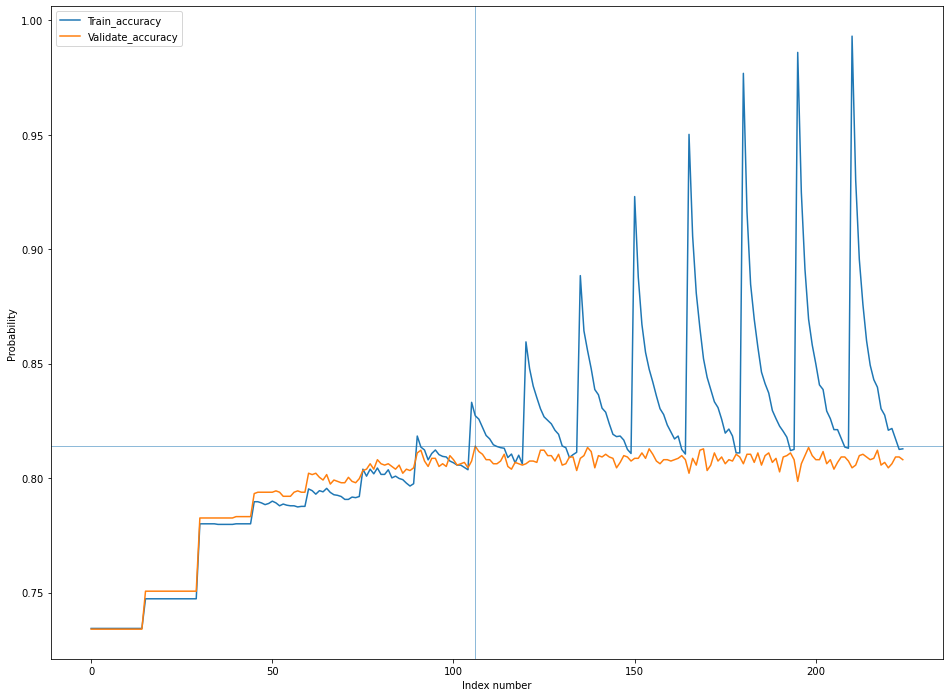

In [76]:
# Visualizing the best performing model #106
results_df[['Train_accuracy', 'Validate_accuracy']].plot(figsize = (16,12))
plt.xlabel('Index number')
plt.ylabel('Probability')
plt.axvline(106, lw =.5, label="Best performer")
plt.axhline(0.813981, lw =.5, label = "Highest accuracy")
0.813981
plt.show()

Using the two hyperparameter max_depth and min_samples_leaf, I've found the best performing model to be max_depth of 8 and 
min_samples_leaf of 2 resulting in Validate accuracy of a 81.4% and Train accuracy of 82.7%.

### K-nearest neighbors

I will start with a single model using standard hyperparameters and tweak it later.

In [77]:
# Using standard hyperparameters to get an idea of the accuracy of KNN model.  Will iterate more later.
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [78]:
# Scoring the model on the train dataset
print(f'Accuracy of KNN classifier on training set: {round(knn.score(X_train, y_train),4)*100}%')

Accuracy of KNN classifier on training set: 81.97%


In [79]:
y_pred = knn.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.844550,0.924594,0.882761,2891.00000
1,0.717617,0.529637,0.609461,1046.00000
accuracy,0.819660,0.819660,0.819660,0.81966
macro avg,0.781083,0.727115,0.746111,3937.00000
weighted avg,0.810826,0.819660,0.810149,3937.00000


This is the best initial result yet, so I will iterate through n_neighbors to give me an idea of how this model might perform with tweaked hyperparamters.

In [80]:
def knn_results(X_train, y_train, X_validate, y_validate):
    results = {}
    K = []
    Train_accuracy = []
    Validate_accuracy = []
    Train_Validate_diff = []
    for x in range(1,21):
        knn = KNeighborsClassifier(n_neighbors=x, weights='uniform')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_train)
        K.append(x)
        Train_accuracy.append(knn.score(X_train, y_train))
        Validate_accuracy.append(knn.score(X_validate, y_validate))
        Train_Validate_diff.append(knn.score(X_train, y_train) - knn.score(X_validate, y_validate))
    results = {"K" : K, "Train_accuracy" : Train_accuracy, "Validate_accuracy" : Validate_accuracy, "Train_Validate_diff" : Train_Validate_diff}
    return results

results_dict = knn_results(X_train, y_train, X_validate, y_validate)


In [81]:
knn_df = pd.DataFrame(results_dict)
knn_df.sort_values("Validate_accuracy", ascending=False)

,K,Train_accuracy,Validate_accuracy,Train_Validate_diff
19,20,0.786894,0.794431,-0.007538
18,19,0.786894,0.794431,-0.007538
16,17,0.789688,0.792654,-0.002966
17,18,0.787148,0.791469,-0.004322
15,16,0.791974,0.789100,0.002874
6,7,0.815596,0.788507,0.027089
14,15,0.796292,0.787915,0.008377
4,5,0.819660,0.787322,0.032337
8,9,0.808992,0.787322,0.021669
13,14,0.795530,0.787322,0.008207


My initial excitement about this model has faded upon seeing the validation accuracy which is under 80% across all results.

### Logistic Regression

I will start with a single model using standard hyperparameters and tweak it later.

In [82]:
# Using standard hyperparameters to get an idea of the accuracy of logistic regression.
logit = LogisticRegression(random_state=123,max_iter=200,)
logit.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=123)

In [83]:
# Scoring the model on the train dataset
print(f'Accuracy of Logistic Regression classifier on training set: {logit.score(X_train, y_train)}')
print(f'Accuracy of Logistic Regression classifier on validate set: {logit.score(X_validate, y_validate)}')

Accuracy of Logistic Regression classifier on training set: 0.7990855981711963
Accuracy of Logistic Regression classifier on validate set: 0.8104265402843602


In [84]:
# Using adjusted hyperparameters shown to work well in past to see how it turns out.  Will iterate more later if needed..
logit = LogisticRegression(random_state=123, penalty='l1', solver = "liblinear")
logit.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=123, solver='liblinear')

In [85]:
# Scoring the model with adjusted hyperparamters on the train dataset
print(f'Accuracy of Logistic Regression classifier on training set: {logit.score(X_train, y_train)}')
print(f'Accuracy of Logistic Regression classifier on validate set: {logit.score(X_validate, y_validate)}')

Accuracy of Logistic Regression classifier on training set: 0.8011176022352045
Accuracy of Logistic Regression classifier on validate set: 0.8074644549763034


Overall results seem to be about normal, but on the low end running about 80% accuracy on train and 80.6% accuracy on validate.

## Additional models tested

### Naïve Bayes

Naïve Bayes is an algorithm that works better with categorical variables than numerical ones. Additionally, if there is strong independence between features then it can do suprisingly well with less training data than other ML algorithms. That said, it doesn't work great in all situations especially if there is not true independence between features.

Just to see, I want to try it here. I will start with a single model using standard hyperparameters and tweak it later if necessary.

For this trial, I will be using both from Gaussian and multinomial Naive Bayes models. I recognize that multinomial probably won't work well here, but I'm curious and want to try.

In [86]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [87]:
# Creating and training the Gaussian Naive Bayes model.
gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)

# Creating and training the Multinomial Naive Bayes model.
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB()

In [88]:
# Scoring the Gaussian model with standard hyperparameters on the train dataset
print(f'Accuracy of Guassian Naive Bayes classifier on training set: {gauss_nb.score(X_train, y_train)}')
print(f'Accuracy of Guassian Naive Bayes classifier on validate set: {gauss_nb.score(X_validate, y_validate)}')

# Scoring the Multinomial model with standard hyperparameters on the train dataset
print(f'Accuracy of Multinomial Naive Bayes classifier on training set: {multi_nb.score(X_train, y_train)}')
print(f'Accuracy of Multinomial Naive Bayes classifier on validate set: {multi_nb.score(X_validate, y_validate)}')

Accuracy of Guassian Naive Bayes classifier on training set: 0.7401574803149606
Accuracy of Guassian Naive Bayes classifier on validate set: 0.7494075829383886
Accuracy of Multinomial Naive Bayes classifier on training set: 0.6616713233426467
Accuracy of Multinomial Naive Bayes classifier on validate set: 0.681872037914692


Both perform very poorly, as such I won't be pursuing them further.

### Support Vector Machines (SVM)

Support Vector machines is another classification model I want to try

For this trial, I will be using both a linear and an rbf kernel to see how they each perform. All other hyperparameters will be kept at defaults.

In [89]:
from sklearn.svm import SVC

In [90]:
# Creating and training the linear SVM model.
linear_svm = SVC(kernel = 'linear')
linear_svm.fit(X_train, y_train)

# Creating and training the rbf SVM model.
rbf_svm = SVC(kernel = 'rbf')
rbf_svm.fit(X_train, y_train)

SVC()

In [91]:
# Scoring the linear SVM model with standard hyperparameters on the train dataset
print(f'Accuracy of linear SVM classifier on training set: {linear_svm.score(X_train, y_train)}')
print(f'Accuracy of linear SVM classifier on validate set: {linear_svm.score(X_validate, y_validate)}')

# Scoring the rbf SVM model with standard hyperparameters on the train dataset
print(f'Accuracy of rbf SVM classifier on training set: {rbf_svm.score(X_train, y_train)}')
print(f'Accuracy of rbf SVM classifier on validate set: {rbf_svm.score(X_validate, y_validate)}')

Accuracy of linear SVM classifier on training set: 0.7912115824231648
Accuracy of linear SVM classifier on validate set: 0.7956161137440758
Accuracy of rbf SVM classifier on training set: 0.7343154686309372
Accuracy of rbf SVM classifier on validate set: 0.7340047393364929


Results for the linear SVM model were slightly worse than other models and results for the rbf SVM model were essentially baseline.
This was a good exercise but I won't continue to follow SVM models here especially since SVM models take a VERY long time to run with this data..

**Conclusion of additional models:** Neither of the additional two models produced better results than the initial four, so I will not pursue them further.

Before choosing a final model or two to tweak hyperparamters on, I want to implement some light feature engineering to see if removing less useful data clears up things and results in better predictive models.

As such I'm going to rerun the original four with total_charges, 'streaming_movies_Yes', 'device_protection_Yes' removed.

In [92]:
# Define X and y train
X_train_engineered = train.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'streaming_movies_Yes', 'device_protection_Yes'])
y_train_engineered = train.churn_Yes

# Define X and y validate
X_validate_engineered = validate.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'streaming_movies_Yes', 'device_protection_Yes'])
y_validate_engineered = validate.churn_Yes

In [93]:
# Create the decision tree model
clf = DecisionTreeClassifier(max_depth=6, random_state=123)

# Fit the model to the train dataset
clf.fit(X_train_engineered, y_train_engineered)

print(f'Accuracy of Decision Tree classifier on training set: {round(clf.score(X_train_engineered, y_train_engineered),4)*100}%')
print(f'Accuracy of Decision Tree classifier on validate set: {round(clf.score(X_validate_engineered, y_validate_engineered),4)*100}%')

Accuracy of Decision Tree classifier on training set: 80.24%
Accuracy of Decision Tree classifier on validate set: 80.57%


best results were with total_charges and streaming_movies_Yes removed

In [94]:
rf = RandomForestClassifier(max_depth=8, random_state=123, min_samples_leaf = 2)
rf.fit(X_train_engineered, y_train_engineered)

print(f'Accuracy of random forest classifier on training set: {round(rf.score(X_train_engineered, y_train_engineered),4)*100}%')
print(f'Accuracy of random forest classifier on validate set: {round(rf.score(X_validate_engineered, y_validate_engineered),4)*100}%')

Accuracy of random forest classifier on training set: 82.47%
Accuracy of random forest classifier on validate set: 80.75%


In [95]:
# Using standard hyperparameters to get an idea of the accuracy of KNN model.  Will iterate more later.
knn = KNeighborsClassifier(n_neighbors=16, weights='uniform')
knn.fit(X_train_engineered, y_train_engineered)

print(f'Accuracy of knn classifier on training set: {round(knn.score(X_train_engineered, y_train_engineered),4)*100}%')
print(f'Accuracy of knn classifier on validate set: {round(knn.score(X_validate_engineered, y_validate_engineered),4)*100}%')

Accuracy of knn classifier on training set: 79.71000000000001%
Accuracy of knn classifier on validate set: 79.44%


In [96]:
# Using standard hyperparameters to get an idea of the accuracy of logistic regression.
logit = LogisticRegression(random_state=123,max_iter=200, penalty='l1', solver = "liblinear")
logit.fit(X_train_engineered, y_train_engineered)

# Scoring the model on the train dataset
print(f'Accuracy of Logistic Regression classifier on training set: {logit.score(X_train_engineered, y_train_engineered)}')
print(f'Accuracy of Logistic Regression classifier on validate set: {logit.score(X_validate_engineered, y_validate_engineered)}')

Accuracy of Logistic Regression classifier on training set: 0.7985775971551943
Accuracy of Logistic Regression classifier on validate set: 0.8033175355450237


**Conclusions:** This feature engineering didn't seem to really help all that much.

The best performing model thus far was the Random Forest model without the above feature engineering, using a max_depth of 8 and min_samples_leaf of 2 which resulted in Validate accuracy of a 81.4% and Train accuracy of 82.7%. I will thus choose this model going forward and do further hyperparameter tuning and feature engineering.

### Hyperparameter Tuning and Feature Engineering for Random Forest Model

I will write a function that iterates through multipal hyperparameters as well as different features being dropped to determine the best performing version of this model.

In [98]:
def rf_super(X_train, y_train, X_validate, y_validate):
    results = {}
    max_depth = []
    min_samples_leaf = []
    n_estimators = []
    criterion = []
    min_samples_split = []
    
    Train_accuracy = []
    Validate_accuracy = []
    Train_Validate_diff = []
    features_dropped = []
    
    for depth in range(1,16):
        for leaf in range(1,8):
            for split in range(2, 10):
                for tree in [100, 500, 1000]:
                    for crit in ['gini', 'entropy']:

                        rf = RandomForestClassifier(max_depth=depth, min_samples_split=split, random_state=123, 
                                                    min_samples_leaf = leaf, n_estimators = tree, criterion= crit)
                        rf.fit(X_train, y_train)

                        max_depth.append(depth)
                        min_samples_leaf.append(leaf)
                        min_samples_split.append(split)
                        n_estimators.append(tree)
                        criterion.append(crit)

                        Train_accuracy.append(rf.score(X_train, y_train))
                        Validate_accuracy.append(rf.score(X_validate, y_validate))
                        Train_Validate_diff.append(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))
    
    results = {"max_depth": max_depth, "min_samples_leaf" : min_samples_leaf, "min_samples_split" : min_samples_split,
               "n_estimators" : n_estimators, "criterion" : criterion, "Train_accuracy" : Train_accuracy, 
               "Validate_accuracy" : Validate_accuracy, "Train_Validate_diff" : Train_Validate_diff}
    
    return results

# results_dict = rf_super(X_train, y_train, X_validate, y_validate)


In [99]:
# This function took about 2 hours to run through.  So for fear of losing this information and having to rerun it again
# I'm going to export it to csv to have as a reference when needed.

# rf_super_results = pd.DataFrame(results_dict)
# rf_super_results.to_csv('rf_super_results.csv', index=False)

# Loading the csv to display here
rf_super_results = pd.read_csv('rf_super_results.csv')

In [100]:

rf_super_results.sort_values(['Validate_accuracy', 'Train_Validate_diff'], ascending = [False, True]).head(15)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,criterion,Train_accuracy,Validate_accuracy,Train_Validate_diff
3890,12,5,2,500,gini,0.853188,0.815166,0.038022
3896,12,5,3,500,gini,0.853188,0.815166,0.038022
3902,12,5,4,500,gini,0.853188,0.815166,0.038022
3908,12,5,5,500,gini,0.853188,0.815166,0.038022
3914,12,5,6,500,gini,0.853188,0.815166,0.038022
3920,12,5,7,500,gini,0.853188,0.815166,0.038022
3926,12,5,8,500,gini,0.853188,0.815166,0.038022
3932,12,5,9,500,gini,0.853188,0.815166,0.038022
3843,12,4,2,500,entropy,0.861062,0.815166,0.045896
3849,12,4,3,500,entropy,0.861062,0.815166,0.045896


It looks like the best models performed with max_depth=12, min_samples_leaf=5, n_estimators=500, criterion='gini', and min_samples_split between 2 and 9.

In [101]:
rf = RandomForestClassifier(max_depth=12, min_samples_split=2, min_samples_leaf=5, n_estimators=500, criterion='gini', random_state=123) 
rf.fit(X_train, y_train)

print(f'Accuracy of random forest classifier on training set: {round(rf.score(X_train, y_train),4)*100}%')
print(f'Accuracy of random forest classifier on validate set: {round(rf.score(X_validate, y_validate),4)*100}%')

Accuracy of random forest classifier on training set: 85.32%
Accuracy of random forest classifier on validate set: 81.52000000000001%


### Slight feature engineering

In [102]:
# I will attempt dropping 'total_charges', 'device_protection_Yes', 'streaming_movies_Yes' as these were determined above
# to be the least useful features and most likely to introduce noise into the model. I want to see if this increases success 
# rate or not.

# Define X and y train
X_train_engineered = train.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'device_protection_Yes', 'streaming_movies_Yes'])
y_train_engineered = train.churn_Yes

# Define X and y validate
X_validate_engineered = validate.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'device_protection_Yes', 'streaming_movies_Yes'])
y_validate_engineered = validate.churn_Yes

rf = RandomForestClassifier(max_depth=12, min_samples_split=2, min_samples_leaf=5, n_estimators=500, criterion='gini', random_state=123) 
rf.fit(X_train_engineered, y_train_engineered)

print(f'Accuracy of random forest classifier on training set: {round(rf.score(X_train_engineered, y_train_engineered),4)*100}%')
print(f'Accuracy of random forest classifier on validate set: {round(rf.score(X_validate_engineered, y_validate_engineered),4)*100}%')

Accuracy of random forest classifier on training set: 84.23%
Accuracy of random forest classifier on validate set: 81.34%


In [103]:
# Leaving in streaming_movies_Yes

# Define X and y train
X_train_engineered = train.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'device_protection_Yes'])
y_train_engineered = train.churn_Yes

# Define X and y validate
X_validate_engineered = validate.drop(columns=['churn_Yes', 'customer_id', 'total_charges', 'device_protection_Yes'])
y_validate_engineered = validate.churn_Yes

rf = RandomForestClassifier(max_depth=12, min_samples_split=2, min_samples_leaf=5, n_estimators=500, criterion='gini', random_state=123) 
rf.fit(X_train_engineered, y_train_engineered)

print(f'Accuracy of random forest classifier on training set: {round(rf.score(X_train_engineered, y_train_engineered),4)*100}%')
print(f'Accuracy of random forest classifier on validate set: {round(rf.score(X_validate_engineered, y_validate_engineered),4)*100}%')

Accuracy of random forest classifier on training set: 84.3%
Accuracy of random forest classifier on validate set: 81.87%


**Feature Engineering Takeaways:** 

Dropping total_charges and device_protection_Yes increases my validate accuracy slightly and brings my training accuracy closer to my validate accuracy.  I will drop these features for the final model test.